# Single Family Parcels in the City of Los Angeles

### By Sharon Ghalchi

For our group project, my team is researching the potential impact that SB8, SB9, and SB10 can make on the supply of affordable housing in the City of Los Angeles. One of our primary data sources will highlight existing single-famiy zoning conditions in the City of Los. This data source will highlight areas in which ADUs and smallplexes are permitted to be constructed. The zoning information for the City of Los Angeles can be found [here](https://geohub.lacity.org/datasets/zoning/explore?location=34.055956%2C-118.234564%2C12.90).

Thus, in this notebook, I will be filtering the zoning information of every parcel in the City of Los Angeles to identify the single-family zoned parcels in which affordable ADUs and smallplexes could potentially be built to. Once I have filtered through the data, I will map my findings. I have already reduced the data size of the original geojson file on `mapshaper.org` since it was much too large. 

## 1. Importing Data

In [1]:
# for general data wrangling tasks
import pandas as pd

# to read and visualize spatial data
import geopandas as gpd

# to provide basemaps 
import contextily as ctx

# to give more power to your figures (plots)
import matplotlib.pyplot as plt

In [2]:
#lets import our data
gdf = gpd.read_file('Data/LA_Zoning.json')

## 2. Preliminary Exploration

I want to get an idea of what my data looks like

In [3]:
# the number of rows and columns 
gdf.shape

(58663, 7)

58663 rows and 7 columms 

In [4]:
# double checking to make sure mapshaper did not change the data type
type(gdf)

geopandas.geodataframe.GeoDataFrame

Geopandas! We're good to go. 

In [5]:
# what does my data table look like?
gdf.head()

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry
0,1,(F)CM-1-CUGU,CM,INDUSTRIAL,0.001376,1.135955e-07,"POLYGON ((-118.38794 34.22863, -118.38794 34.2..."
1,2,(F)CM-1-CUGU,CM,INDUSTRIAL,0.001376,1.136063e-07,"POLYGON ((-118.38794 34.22959, -118.38795 34.2..."
2,3,(F)CM-1-CUGU,CM,INDUSTRIAL,0.001102,5.680651e-08,"POLYGON ((-118.38795 34.23014, -118.38795 34.2..."
3,4,(F)CM-1-CUGU,CM,INDUSTRIAL,0.001102,5.680455e-08,"POLYGON ((-118.38795 34.23041, -118.38795 34.2..."
4,5,(F)CM-1-CUGU,CM,INDUSTRIAL,0.001376,1.136150e-07,"POLYGON ((-118.38795 34.23140, -118.38796 34.2..."


Okay it looks like we have an object ID column followed by three different categorization categories, two shape/float columns, and a geometry/location column.

In [6]:
# here is a summary of it all
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58663 entries, 0 to 58662
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      58663 non-null  int64   
 1   ZONE_CMPLT    58663 non-null  object  
 2   ZONE_CLASS    58663 non-null  object  
 3   ZONE_SMRY     58537 non-null  object  
 4   SHAPE_Length  58663 non-null  float64 
 5   SHAPE_Area    58663 non-null  float64 
 6   geometry      58663 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 3.1+ MB


Even after I put the geojson into mapshaper, the memory is still 3.1+ MB which somewhat worries me. I cleaned my data and simplified the data to 10%. Let's hope this doesn't crash.

## 3. Data Values

I want to look at the value options/counts in our object columns.

### Zoning Summary 

In [7]:
gdf['ZONE_SMRY'].value_counts()

RESIDENTIAL        36534
COMMERCIAL         11095
INDUSTRIAL          3663
AGRICULTURE         2445
PUBLIC FACILITY     2100
OPEN SPACE          1451
PARKING             1249
Name: ZONE_SMRY, dtype: int64

Okay, so this column let's me know what land use type each parcel has. I know that I want to look at the residential parcels, so this could be useful.

### Zone Class

In the LA, the zone class is defined as: *the types of uses that are permitted on a property, including regulations related to building setbacks and minimum lot size requirements.* Let's take a look at the zone classes in this data set.

In [8]:
gdf['ZONE_CLASS'].value_counts()

R1        12768
C2         8023
R3         5045
RD1.5      3370
R2         3329
          ...  
PVSP          1
M2(PV)        1
USC-1A        1
CCS           1
A2P           1
Name: ZONE_CLASS, Length: 111, dtype: int64

Now this column tells me the actual zoning classification of the parcel. Downside, there are 111 unique values in this column. Upside, I only need the single family zone classes, so I won't really need to look into all 111 unique classifications. However, I might want to look at all the different classifications within the residential land use parcels.

### Zoning Code

By looking at the data table generated above, I can tell that the `ZONE_CMPLT` is giving us the complete zoning code for each parcel. The complete code gives us extra information like how tall a building on a property can be or if the parcel fall in a planning overlay districts. Let's take a look at how many unique values we have. 

In [9]:
gdf['ZONE_CMPLT'].value_counts()

R1-1           7914
RS-1           2442
R3-1           2383
R2-1           1713
C2-1VL-CPIO    1377
               ... 
[Q]A2-1           1
R1-1-K-RFA        1
(T)RS-1-K         1
(Q)RD4-1XL        1
A2P-1             1
Name: ZONE_CMPLT, Length: 1941, dtype: int64

There are 1941 unique values which is a lot. For the purposes of our research, we don't really need to know the entire zoning code of each parcel. All we need to know is the actual zone class. Thus, I can somewhat ignore this column. I won't delete it just yet because I may find use for it in the future.  

## 4. Filtering Data

### Residential Land Use 

I want to start off by filtering for the residential land use parcels only. This will help me trim the number of zone classes I can use.

In [10]:
gdf.query("ZONE_SMRY == 'RESIDENTIAL'")

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry
10,11,(F)R2-1-RIO,R2,RESIDENTIAL,0.003084,5.452941e-07,"POLYGON ((-118.48039 34.19086, -118.47940 34.1..."
11,12,(F)R2-1-RIO,R2,RESIDENTIAL,0.002809,3.635111e-07,"POLYGON ((-118.47939 34.19182, -118.47940 34.1..."
12,13,(F)R2-1-RIO,R2,RESIDENTIAL,0.003358,6.816327e-07,"POLYGON ((-118.47940 34.19265, -118.47940 34.1..."
13,14,(F)RE11-1,RE11,RESIDENTIAL,0.002197,2.039770e-07,"POLYGON ((-118.46579 34.32016, -118.46516 34.3..."
14,15,(F)RE11-1,RE11,RESIDENTIAL,0.002240,2.223388e-07,"POLYGON ((-118.46643 34.32065, -118.46579 34.3..."
...,...,...,...,...,...,...,...
58575,58576,[Q]R1-1D,R1,RESIDENTIAL,0.011773,2.462393e-06,"POLYGON ((-118.19818 34.07555, -118.19818 34.0..."
58576,58577,R1-1,R1,RESIDENTIAL,0.007004,1.775233e-06,"POLYGON ((-118.44049 34.20476, -118.44110 34.2..."
58581,58582,(T)R1-1,R1,RESIDENTIAL,0.002036,2.272604e-07,"POLYGON ((-118.52513 34.22788, -118.52513 34.2..."
58582,58583,(T)(Q)RD3-1,RD3,RESIDENTIAL,0.002211,2.155164e-07,"POLYGON ((-118.45261 34.23747, -118.45261 34.2..."


Let's define this query as *residential*

In [11]:
residential = gdf.query("ZONE_SMRY == 'RESIDENTIAL'").copy()
residential

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry
10,11,(F)R2-1-RIO,R2,RESIDENTIAL,0.003084,5.452941e-07,"POLYGON ((-118.48039 34.19086, -118.47940 34.1..."
11,12,(F)R2-1-RIO,R2,RESIDENTIAL,0.002809,3.635111e-07,"POLYGON ((-118.47939 34.19182, -118.47940 34.1..."
12,13,(F)R2-1-RIO,R2,RESIDENTIAL,0.003358,6.816327e-07,"POLYGON ((-118.47940 34.19265, -118.47940 34.1..."
13,14,(F)RE11-1,RE11,RESIDENTIAL,0.002197,2.039770e-07,"POLYGON ((-118.46579 34.32016, -118.46516 34.3..."
14,15,(F)RE11-1,RE11,RESIDENTIAL,0.002240,2.223388e-07,"POLYGON ((-118.46643 34.32065, -118.46579 34.3..."
...,...,...,...,...,...,...,...
58575,58576,[Q]R1-1D,R1,RESIDENTIAL,0.011773,2.462393e-06,"POLYGON ((-118.19818 34.07555, -118.19818 34.0..."
58576,58577,R1-1,R1,RESIDENTIAL,0.007004,1.775233e-06,"POLYGON ((-118.44049 34.20476, -118.44110 34.2..."
58581,58582,(T)R1-1,R1,RESIDENTIAL,0.002036,2.272604e-07,"POLYGON ((-118.52513 34.22788, -118.52513 34.2..."
58582,58583,(T)(Q)RD3-1,RD3,RESIDENTIAL,0.002211,2.155164e-07,"POLYGON ((-118.45261 34.23747, -118.45261 34.2..."


Now that I have filtered for residential land use, I can take a look at the residential zone classes to find the ones that apply to single family residential lots. 

In [12]:
residential['ZONE_CLASS'].value_counts()

R1          12768
R3           5045
RD1.5        3370
R2           3329
RS           2851
RD2          2079
R4           1265
RE11         1217
R1V2          824
RE15          760
RD3           702
RE40          417
RE9           304
RE20          278
R1R3          245
R5            140
RAS4          139
RD6           119
R1V3          116
RD5            92
R1V1           69
RD4            67
R1H1           47
RAS3           44
RW1            36
RMP            35
R3P            24
R4P            22
R1P            20
R4(PV)         20
RAS3(UV)       16
RZ3            12
R5P            11
RW2            10
RZ4             7
RZ5             7
R3(PV)          6
R3(UV)          6
RE              5
RZ2.5           5
R2P             2
RU              2
RSP             1
Name: ZONE_CLASS, dtype: int64

Now I can see exactly what the different zone class options for residntial land uses are. The single family zone classifications with the sufficient minimum rear yard setback requirement to build an ADU are: R1, RS, RU, R1V1, R1V2, RIV3, R1P, R1R3, R1H1, R1P, RW1, RE, RE9, RE11, RE15, RE20, RE40. ([source](https://planning.lacity.org/odocument/eadcb225-a16b-4ce6-bc94-c915408c2b04/Zoning_Code_Summary.pdf)). I double checked our zone class values listed above to make sure the the codes match. They do! Thus, I want to filter my data for those parcels.


### Single Family Parcels

In [13]:
# I want to define a list of my filtered categories
filter_list = ['R1', 'RS', 'RU', 'R1V1', 'R1V2', 'RIV3', 'R1P', 'R1R3', 'R1H1', 'R1P', 'RW1', 'RE', 'RE9', 'RE11', 'RE15', 'RE20', 'RE40']

In [14]:
#Now I filter my data for single family residential parcels using my filtered zone classes.
gdf[gdf.ZONE_CLASS.isin(filter_list)]

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry
13,14,(F)RE11-1,RE11,RESIDENTIAL,0.002197,2.039770e-07,"POLYGON ((-118.46579 34.32016, -118.46516 34.3..."
14,15,(F)RE11-1,RE11,RESIDENTIAL,0.002240,2.223388e-07,"POLYGON ((-118.46643 34.32065, -118.46579 34.3..."
292,293,R1-1,R1,RESIDENTIAL,0.002181,2.471552e-07,"POLYGON ((-118.55781 34.20746, -118.55750 34.2..."
293,294,(Q)R1-1,R1,RESIDENTIAL,0.004872,6.329446e-07,"POLYGON ((-118.58963 34.22095, -118.58963 34.2..."
294,295,(Q)R1-1,R1,RESIDENTIAL,0.004019,3.750881e-07,"POLYGON ((-118.48842 34.22792, -118.48889 34.2..."
...,...,...,...,...,...,...,...
58572,58573,R1-1-CUGU,R1,RESIDENTIAL,0.002523,3.548346e-07,"POLYGON ((-118.36989 34.23047, -118.36924 34.2..."
58574,58575,[Q]RE20-1D,RE20,RESIDENTIAL,0.001126,2.483553e-08,"POLYGON ((-118.19818 34.07555, -118.19811 34.0..."
58575,58576,[Q]R1-1D,R1,RESIDENTIAL,0.011773,2.462393e-06,"POLYGON ((-118.19818 34.07555, -118.19818 34.0..."
58576,58577,R1-1,R1,RESIDENTIAL,0.007004,1.775233e-06,"POLYGON ((-118.44049 34.20476, -118.44110 34.2..."


We now have 18,597 parcels with sufficient single family zoning. This can mean 18,597 potential ADUs!

In [15]:
#Define this list
single_family = gdf[gdf.ZONE_CLASS.isin(filter_list)].copy()
single_family

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry
13,14,(F)RE11-1,RE11,RESIDENTIAL,0.002197,2.039770e-07,"POLYGON ((-118.46579 34.32016, -118.46516 34.3..."
14,15,(F)RE11-1,RE11,RESIDENTIAL,0.002240,2.223388e-07,"POLYGON ((-118.46643 34.32065, -118.46579 34.3..."
292,293,R1-1,R1,RESIDENTIAL,0.002181,2.471552e-07,"POLYGON ((-118.55781 34.20746, -118.55750 34.2..."
293,294,(Q)R1-1,R1,RESIDENTIAL,0.004872,6.329446e-07,"POLYGON ((-118.58963 34.22095, -118.58963 34.2..."
294,295,(Q)R1-1,R1,RESIDENTIAL,0.004019,3.750881e-07,"POLYGON ((-118.48842 34.22792, -118.48889 34.2..."
...,...,...,...,...,...,...,...
58572,58573,R1-1-CUGU,R1,RESIDENTIAL,0.002523,3.548346e-07,"POLYGON ((-118.36989 34.23047, -118.36924 34.2..."
58574,58575,[Q]RE20-1D,RE20,RESIDENTIAL,0.001126,2.483553e-08,"POLYGON ((-118.19818 34.07555, -118.19811 34.0..."
58575,58576,[Q]R1-1D,R1,RESIDENTIAL,0.011773,2.462393e-06,"POLYGON ((-118.19818 34.07555, -118.19818 34.0..."
58576,58577,R1-1,R1,RESIDENTIAL,0.007004,1.775233e-06,"POLYGON ((-118.44049 34.20476, -118.44110 34.2..."


In [16]:
# Let's check distribution 
single_family['ZONE_CLASS'].value_counts()

R1      12768
RS       2851
RE11     1217
R1V2      824
RE15      760
RE40      417
RE9       304
RE20      278
R1R3      245
R1V1       69
R1H1       47
RW1        36
R1P        20
RE          5
RU          2
Name: ZONE_CLASS, dtype: int64

## 5. Plot Data

In [17]:
# Let's define our new value count
single_family_count = single_family['ZONE_CLASS'].value_counts()
single_family_count

R1      12768
RS       2851
RE11     1217
R1V2      824
RE15      760
RE40      417
RE9       304
RE20      278
R1R3      245
R1V1       69
R1H1       47
RW1        36
R1P        20
RE          5
RU          2
Name: ZONE_CLASS, dtype: int64

In [18]:
# Let's convert the series into a dataframe so that I can easily plot it
single_family_count.reset_index()

,index,ZONE_CLASS
0,R1,12768
1,RS,2851
2,RE11,1217
3,R1V2,824
4,RE15,760
5,RE40,417
6,RE9,304
7,RE20,278
8,R1R3,245
9,R1V1,69


In [19]:
# Double check that it worked
type(single_family_count)

pandas.core.series.Series

In [20]:
# Redefine columns
single_family_count.columns = ['Zone_Class', 'Count']

In [21]:
single_family_count.columns

['Zone_Class', 'Count']

Text(0.5, 1.0, 'Number of Parcels Per Single Family Zone Class')

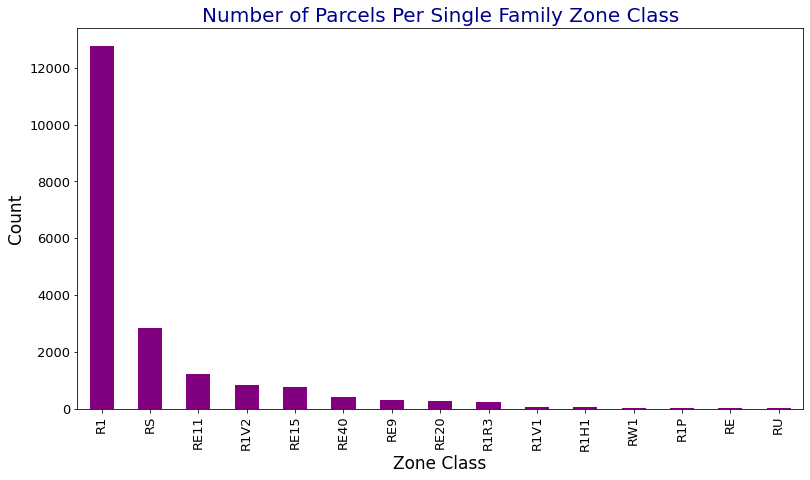

In [22]:
# Finally, let's plot!
single_family_count.plot.bar(figsize=(13,7), x = 'Zone_Class', fontsize = 13, y = 'Count', color = 'purple')

plt.xlabel('Zone Class', fontsize=17)
plt.ylabel('Count', fontsize=17)
plt.title('Number of Parcels Per Single Family Zone Class', fontsize=20, color = 'darkblue')





Okay, so the majority of these by far are R1.

## 6. Mapping Single Family Parcels

Now let's map our filtered data!

I want to start with every single single family zone class. 

<AxesSubplot:>

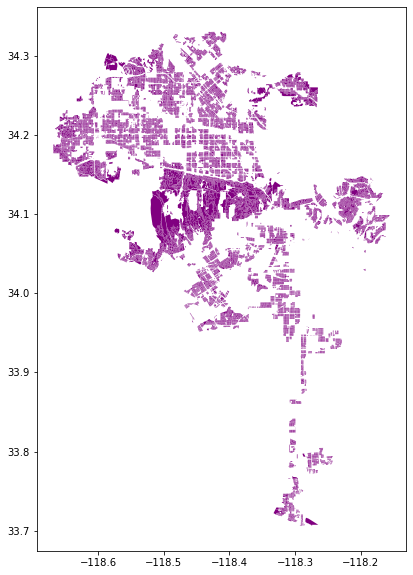

In [23]:
single_family.plot(figsize=(10,10), color = 'purple')

Now, I want to make each zone class a different color. 

<AxesSubplot:>

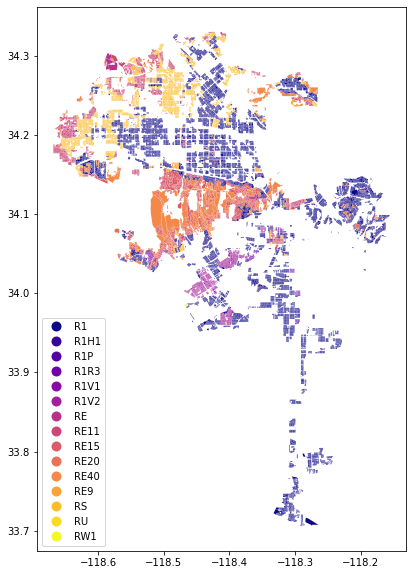

In [24]:
single_family.plot(
            figsize=(10,10),   #size of the plot (a bit bigger than the default)
            column = 'ZONE_CLASS',  #our zone class column 
            cmap = 'plasma', legend = True,     # add a legend           
            legend_kwds={
               'loc': 'lower left',
            }                 
) 


## 7. Adding a Basemap

Before adding web map tiles to these plots, I need to ensure the coordinate reference systems (CRS) of the tiles and the data match. Web map tiles are typically provided in Web Mercator (EPSG 3857), so let us first check what CRS we are in.

Let's start with the single family map.

In [25]:
single_family.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we know the CRS do not match, so we need to choose in which CRS we wish to visualize the data: either the CRS of the tiles, the one of the data, or even a different one.

The first option to match CRS is to leverage the `to_crs` method of GeoDataFrames to convert the CRS of our data, here to Web Mercator:

In [26]:
single_family_wm = single_family.to_crs(epsg=3857)

We can then use `add_basemap` function of contextily to easily add a background map to our plot:

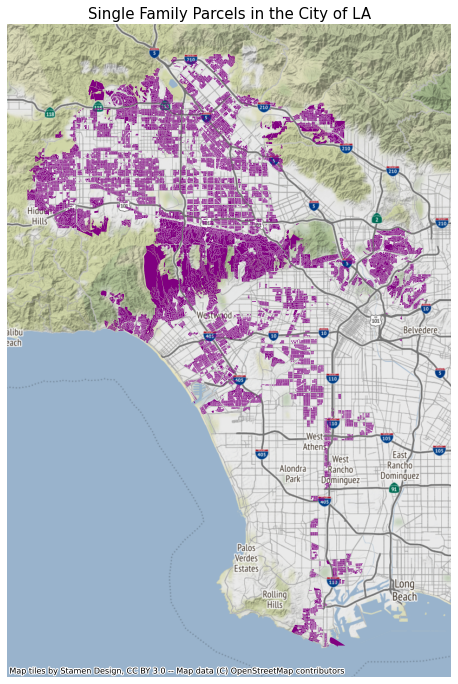

In [27]:
ax = single_family_wm.plot(figsize=(12,12), color = 'purple')
ax.set_title('Single Family Parcels in the City of LA', fontsize=15)
ax.axis('off')
ctx.add_basemap(ax)

Well that definetly looks like an outline of LA. We can also see that single family zoning is concentrated in some areas an not so much in others. It will be interesting to overlay an outline of LA city boundaries so we can get a better idea of where single family zoning is more prominant than others. 

Now let's do our single family zone code map. This way we can also geet an idea of where each zone code is most prominant.

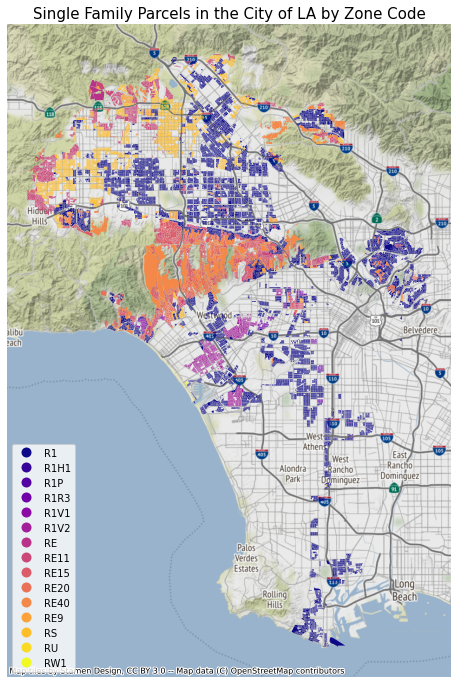

In [28]:
ax = single_family_wm.plot(
            figsize=(12,12),   
            column = 'ZONE_CLASS',  
            cmap = 'plasma', alpha = 1, legend = True,           
            legend_kwds={
               'loc': 'lower left',
            }        
) 
ax.axis('off')
ax.set_title('Single Family Parcels in the City of LA by Zone Code', fontsize=15)
ctx.add_basemap(ax)

Okay, so we can clearly see that different zone codes are prominant in different areas. However, R1 zoning is dispersed throughout the city.

I want to do a map of only the R1 Zone Code parcels since they made up a majority of our single family parcels and they are the most dispersed. R1 zoning is also known as our traditional single-family residential zone class. I'll use the same dark blue color it is categorized in the map above.

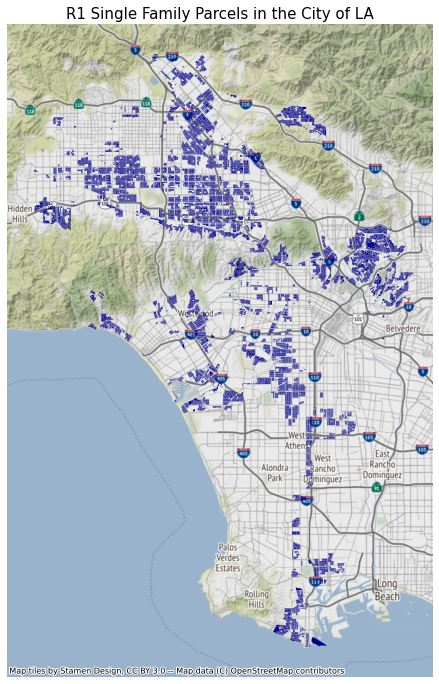

In [29]:
ax = single_family_wm[single_family_wm['ZONE_CLASS'] == 'R1'].plot(figsize=(12,12), color = 'darkblue')
ax.set_title('R1 Single Family Parcels in the City of LA', fontsize=15)
ax.axis('off')
ctx.add_basemap(ax)

Now I want to do a subplot map with both R1 and RS zone code parcels. When we made our chart above, R1 was the most 

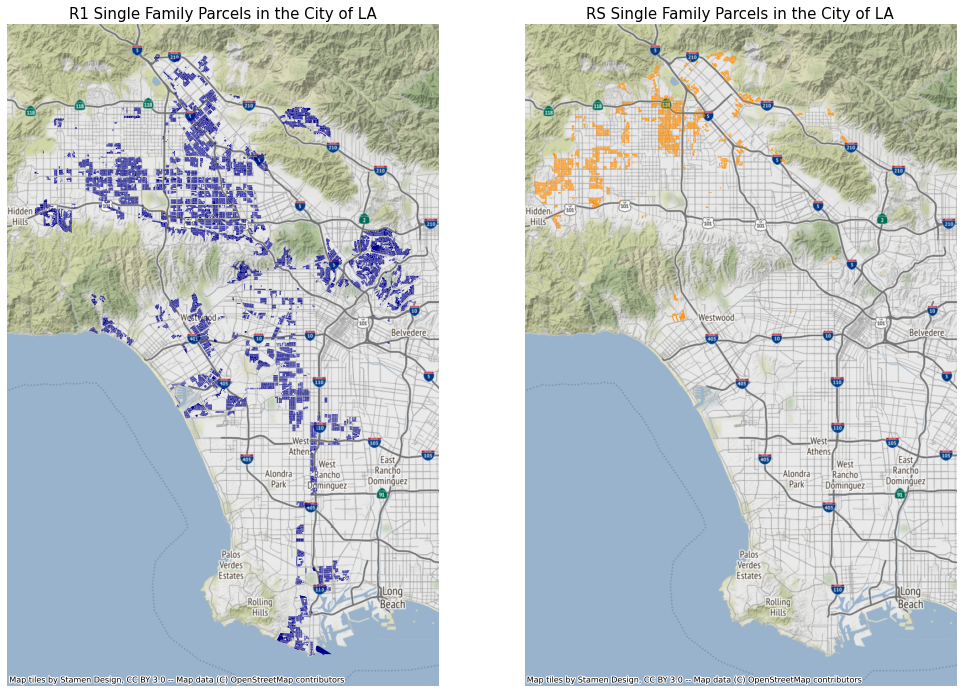

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(17, 17), sharey=True, sharex=True,)
ax1, ax2 = axs

single_family_wm[single_family_wm['ZONE_CLASS'] == 'R1'].plot(figsize=(15,15), color = 'darkblue', linewidth = 0, alpha = 1, ax = ax1)
ax1.axis('off')
ax1.set_title('R1 Single Family Parcels in the City of LA', fontsize=15)
ctx.add_basemap(ax1)

single_family_wm[single_family_wm['ZONE_CLASS'] == 'RS'].plot(figsize=(15,15), color = 'darkorange', linewidth = 0, alpha = 1, ax = ax2)
ax2.axis('off')
ax2.set_title('RS Single Family Parcels in the City of LA', fontsize=15)
ctx.add_basemap(ax2)



Here we see that although R1 zoning is dispersed throughout the City of LA, RS zoning is mostly found in the north east of the city. This makes sense since RS zoning is known as single family suburban zoning and the north west of the city is the suburbs. However, R1 is still also prominent here. It would be interesting to understand why the city needed to distinguish between R1 and RS zoning. Additionally, it would be interesting to see if there is more or less affordable housing where RS zoning is more prominant than R1 zoning. 

There you have it folks, a look into the potential locations of new ADUs and smallplexes in the City of Los Angeles!